In [164]:
!pip install sentence_transformers
!pip install elasticsearch==7.10.1
!pip install numpy==1.21.6
!wget https://gist.githubusercontent.com/h3xx/1976236/raw/bbabb412261386673eff521dddbe1dc815373b1d/wiki-100k.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://artifactory.build.ue1.snooguts.net/artifactory/api/pypi/reddit-python-prod/simple
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://artifactory.build.ue1.snooguts.net/artifactory/api/pypi/reddit-python-prod/simple
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid

## Encoded sentences

Encode 100K wikipedia sentences

In [165]:
import numpy as np
# encoded every nth sentence
encode_every = 10

try:
    with open('wikisent10.npz', 'rb') as f:
        vects = np.load(f)
  
    with open('wikisent10.txt', 'rt') as f:
        sentences = f.readlines()

except FileNotFoundError:
    import gzip
    from sentence_transformers import SentenceTransformer
    model = SentenceTransformer('all-MiniLM-L6-v2')

    vects = []
    sentences = []

    with gzip.open('wikisent2.txt.gz', 'rt') as f:
        for idx, line in enumerate(f):
            if idx % encode_every == 0:
                # print(idx, str(line))
                vects.append(model.encode(line))
                sentences.append(line)
                
            if idx % 1000 == 0:
                print(idx)

    with open('wikisent10.npz', 'wb') as f:
        np.save(f, vects)

    with open('wikisent10.txt', 'wt') as f:
        f.writelines(sentences)

In [166]:
import numpy as np

vects = np.stack(vects)
vects.shape

(787183, 384)

In [167]:
all_normed = (np.linalg.norm(vects, axis=1) > 0.99) & (np.linalg.norm(vects, axis=1) < 1.01)
assert all_normed.all(), "Normalization of the vectors failed!"

In [168]:
query_vector = vects[100]
query_sentence = sentences[100]
query_sentence, query_vector

('10 in the UK Singles chart, however it was a bigger hit for Amazulu in 1986 from their album Amazulu.\n',
 array([-1.65669695e-02, -5.89489937e-03, -2.46185139e-02,  3.49459201e-02,
        -5.96193708e-02,  4.54125032e-02,  1.43240886e-02,  1.26762286e-01,
        -1.63968687e-03, -5.66748949e-03,  2.10027415e-02, -2.02863980e-02,
         8.11159387e-02, -2.67713349e-02, -2.89963521e-02,  8.08742493e-02,
        -8.47459882e-02, -6.14119321e-02, -5.81718162e-02, -1.00160554e-01,
         3.72661687e-02,  3.74510232e-03,  3.22895274e-02, -2.68099103e-02,
         2.89040431e-02, -5.74016534e-02, -6.42961562e-02, -3.60523909e-02,
         1.64815579e-02,  1.49551164e-02,  5.87281212e-03,  8.31465349e-02,
         3.00437957e-02, -9.65476856e-02, -1.39308292e-02, -9.16170850e-02,
         3.82585377e-02, -5.17641939e-02,  3.13696228e-02, -1.28319385e-02,
         5.40856160e-02,  1.58545915e-02,  3.15750134e-03, -9.86583158e-02,
         3.50489616e-02, -3.42526808e-02, -7.54494891e-0

In [169]:
assert (np.linalg.norm(query_vector) > 0.99) & (np.linalg.norm(query_vector) < 1.01), "Normalization failed on query vector"

## Numpy cosine similarity

In [107]:
# def cosine_similarity(query_vector, vectors, n=100):
#     """ nth nearest neighbors as array
#         with indices of nearest neighbors"""

#     dotted = np.dot(normed, query_normed)
#     dotted = np.divide(dotted, normed)
#     # top_n = np.argpartition(-nn, n)[:n]
#     # return top_n, nn[top_n]
#     return dotted
  
nn = np.dot(vects, query_vector)
top_n = np.argpartition(-nn, 10)[:10]
top_n = top_n[nn[top_n].argsort()[::-1]]

# Confirm sorting
assert (sorted(nn[top_n], reverse=True) == nn[top_n]).all()
for idx in top_n:
    print(idx, nn[idx], sentences[idx])

100 0.99999994 1983 All-Ireland Minor Hurling Championship was the 53rd staging of the All-Ireland Minor Hurling Championship since its establishment by the Gaelic Athletic Association in 1928.

2535 0.92466676 All-Ireland Minor Hurling Championship was the 16th staging of the All-Ireland Minor Hurling Championship since its establishment by the Gaelic Athletic Association in 1928.

2537 0.7731979 All-Ireland Senior Hurling Championship Final was the 40th All-Ireland Final and the culmination of the 1927 All-Ireland Senior Hurling Championship, an inter-county hurling tournament for the top teams in Ireland.

53752 0.7037497 The 1999 All-Ireland Intermediate Hurling Championship was the 16th staging of the All-Ireland hurling championship.

53785 0.68757546 The 2001 Cork Junior Hurling Championship was the 105th staging of the Cork Junior Hurling Championship since its establishment by the Cork County Board in 1895.

53777 0.681895 The 2000 Cork Junior Hurling Championship was the 104t

## Zipfian nearest neighbors algorithm

1. Randomly draw x in 1..N
2. Find the zipfian probability of x
3. Find an arbitrary part of the vector space as the centroid
4. Scale the radius to zipfian probability of x
5. Assign every vector within radius to this region

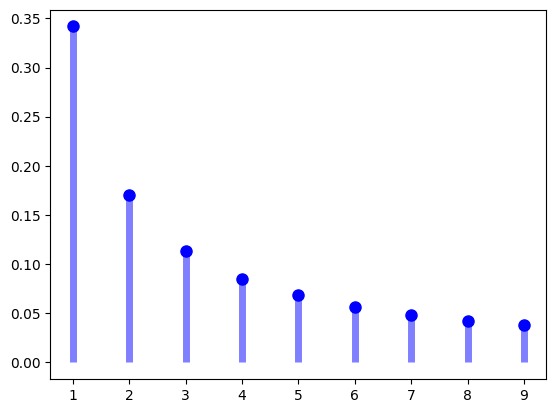

In [170]:
# Randomly draw 1..32000, 
from scipy.stats import zipfian
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, n = 1.001, 10

x = np.arange(zipfian.ppf(0.0001, a, n),
              zipfian.ppf(0.99999999999, a, n))

ax.plot(x, zipfian.pmf(x, a, n), 'bo', ms=8, label='zipfian pmf');
ax.vlines(x, 0, zipfian.pmf(x, a, n), colors='b', lw=5, alpha=0.5);

## Use actual terms corresponding to zipfian location

For a bit of flare, and to play well with a full text search engine, lets use terms actually corresponding to zipfian distribution of terms.

In [171]:
terms = []
with open('wiki-100k.txt') as f:
    for line in f:
        if not line[0] == "#":
            terms.append(line.strip().lower())
  
terms[:10]

def term_at(ordinal):
    try:
        return terms[ordinal]
    except IndexError:
        return f"term_{ordinal}"

In [172]:
terms[:10]

['the', 'of', 'and', 'to', 'a', 'in', 'that', 'i', 'was', 'he']

## Define a specificity function or `radius`

Define a function that lets us compute the specificity of a randomly chosen term. With a minimum number of documents.

Specificity is defined by the zipfian probability distribution. A zipfian of 1 will be close to probability of 1 (`the` occurs in every document). This is a vector and radius encompassing all of the vectors being indexed. A zipfian closer to max_vects will have a floor of matching at least min_vects close to the chosen centroid.

In [339]:
num_terms = len(terms)
from math import log
num_vectors = len(vects)

def radius(ordinal, a=1.1):
    """Keep all vectors of cos similarity."""
    probability = zipfian.pmf(ordinal, a, ordinal)
    # Make this a bit more mathematically robust,
    # this ranges from -1 to 0.2
    # Scale from -0.2 to 0.2
    return 0.25
    return -((probability * 0.4) - 0.2)



specificity = radius(10)
specificity

0.25

## Run the algorithm

1. Draw a random term ordinal
2. Find its specificity

In [340]:
psuedo_docs = {}
term_ordinal = np.random.choice(num_terms)
specificity = radius(term_ordinal)
term = term_at(term_ordinal)
specificity, term_ordinal, term

(0.25, 91971, "markham's")

## Choose a random vector

In [341]:
random_vect = vects[np.random.choice(num_vectors)]
random_vect

array([ 2.91597787e-02, -7.99298361e-02,  3.00034117e-02, -3.60662229e-02,
       -2.92981882e-02,  7.46293813e-02, -1.02937214e-01, -1.37860430e-02,
       -7.10703339e-03, -3.28483875e-05, -3.79858129e-02, -5.14875539e-02,
       -1.05719142e-01, -2.10369360e-02, -3.70543450e-02,  2.31566709e-02,
        3.53991836e-02,  4.68087420e-02, -5.13439216e-02,  1.79782026e-02,
        2.02267990e-02, -1.70046855e-02,  3.78207155e-02,  6.83886334e-02,
        2.24799588e-02,  2.67461501e-02, -4.12822329e-02, -2.71987114e-02,
       -2.90968101e-02,  2.73936149e-02, -4.24317569e-02, -1.27183780e-01,
       -2.09757797e-02,  8.57990421e-03,  2.03365483e-03,  2.87608076e-02,
       -4.20561358e-02, -2.50550732e-02,  3.62731256e-02,  6.44478127e-02,
        2.09630132e-02, -1.09597959e-01, -8.08249861e-02,  2.76805330e-02,
       -5.07117016e-03, -4.71939705e-03, -8.86809826e-02, -2.02392694e-03,
        1.47901420e-02, -9.06967372e-02, -3.92600223e-02, -4.78372127e-02,
        7.74129061e-04, -

## Compute most similar, within the 'radius' of the selected specificity

1. Take dot product for cosine similarity
2. Get top N above threshold

In [342]:
def most_similar_at_specificity(centroid, specificity):

    nn = np.dot(vects, centroid)
    nn_above_thresh = nn.copy()
    nn_above_thresh[nn_above_thresh >= specificity] = nn_above_thresh[nn_above_thresh >= specificity]
    nn_above_thresh[nn_above_thresh < specificity] = 0

    vectors_above_thresh = np.argwhere(nn_above_thresh)[:, 0]
    return sorted(zip(vectors_above_thresh, nn_above_thresh[vectors_above_thresh]),
                key=lambda vect: vect[1],
                reverse=True)

nn_above_thresh = most_similar_at_specificity(random_vect, specificity)
nn_above_thresh[:10]

[(60442, 0.99999994),
 (494086, 0.69436383),
 (184749, 0.6760327),
 (668672, 0.67161804),
 (209791, 0.66237557),
 (668675, 0.6508068),
 (184730, 0.6489823),
 (494639, 0.64784807),
 (496341, 0.6463667),
 (500756, 0.63914675)]

## Label with terms

Term X (like `cat`) has a given specificity (lets say 3% of vectors). We have arbitrarilly selected a space where `cat` lives and assigned some 3% of indexed_vectors to it. So all we need to do is update the dictionary with `cat`

In [343]:
psuedo_docs = {}

for vector_ord, sim in nn_above_thresh:
    sim = int(sim * 10)
    try:
        psuedo_docs[vector_ord] = psuedo_docs[vector_ord].extend([term] * sim)
    except KeyError:
        psuedo_docs[vector_ord] = [term] * sim

list(psuedo_docs.items())[:10]

[(60442,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's"]),
 (494086,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's"]),
 (184749,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's"]),
 (668672,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's"]),
 (209791,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's"]),
 (668675,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's"]),
 (184730,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's"]),
 (494639,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's"]),
 (496341,
  ["markham's",
   "markham's",
   "markham's",
   "markham's",
   "markham's",

## Select a centroid based on specificity

Less specificic, average more of the space, to ensure more is included

In [344]:
def centroid(specificity):
    dot_prod = 0.0
    while dot_prod < specificity:
        random_vect = vects[np.random.choice(num_vectors)]
        other_vect = vects[np.random.choice(num_vectors)]
        dot_prod = np.dot(random_vect, other_vect)
        
    selected_centroid = random_vect + other_vect 
    selected_centroid /= np.linalg.norm(selected_centroid)
    return selected_centroid

centroid(0.25)

array([-9.06293392e-02,  1.19261732e-02, -7.61917531e-02, -1.42635368e-02,
       -3.50325815e-02,  5.44482702e-03,  3.51777487e-02,  5.25707491e-02,
       -6.39411900e-03, -8.55034497e-03, -2.62874607e-02, -9.97025636e-04,
        3.20825428e-02,  3.25029194e-02, -7.88980909e-03, -1.16719780e-02,
       -4.55783643e-02,  2.49791108e-02, -3.48427594e-02, -6.53581098e-02,
       -3.55727635e-02,  1.02111965e-01,  1.79974437e-02, -1.12887425e-02,
        1.16129667e-02, -2.11977344e-02, -6.95902705e-02,  4.45792302e-02,
       -3.19727771e-02, -2.73406152e-02,  7.09351199e-03,  3.10497754e-03,
       -1.67216850e-03,  9.65219364e-03, -1.72403753e-02,  8.70355219e-03,
       -1.09138619e-02,  4.37625907e-02,  7.74501041e-02, -2.05978844e-02,
        1.15726506e-02, -7.47224241e-02,  1.03792911e-02, -1.54504953e-02,
       -1.03224181e-01, -3.81244868e-02, -7.84532949e-02,  9.87676065e-03,
        8.86006728e-02, -1.97781366e-03, -2.74730045e-02,  2.75032744e-02,
       -4.36886176e-02, -

## Put it together iteratively...

Perform the above algorithm, looping over up to N term ordinals. We also build an `iverted_index` to track when vectors/docs go with each term, and a reverse map of terms to their vector centroid.

In [345]:
psuedo_docs = {}      # vect_ids -> list of terms
inverted_index = {}   # term -> vect_ids  
similarities = {}     # term -> similarity (parallel to inverted index)
term_vects = {}       # terms -> vect centroids

# Run N times, more times, slower, but more accurate index
num_terms_to_index = 100

all_indexed_vectors = set()

for term_ordinal in range(1,num_terms_to_index):
    term = term_at(term_ordinal-1)

    specificity = 0.1
    center = centroid(specificity)

    top_n = most_similar_at_specificity(center, specificity)

    if (term_ordinal < 10) or (term_ordinal % 100 == 0):
        print(term_ordinal, term, specificity, specificity, len(top_n))

    for vector_ord in top_n:
        term_vects[term] = center
        try:
            inverted_index[term].append(vector_ord)
        except KeyError:
            inverted_index[term] = [vector_ord]
        # all_indexed_vectors.add(vector_ord[0])
        if vector_ord[0] == 29817:
            print('Q', term_ordinal, term)
    # print(len(set(all_indexed_vectors)) / len(vects))


1 the 0.1 0.1 223865
2 of 0.1 0.1 303905
3 and 0.1 0.1 300439
4 to 0.1 0.1 192477
5 a 0.1 0.1 259124
6 in 0.1 0.1 181504
7 that 0.1 0.1 242527
8 i 0.1 0.1 179901
Q 8 i
9 was 0.1 0.1 148124
Q 22 at
Q 33 she
Q 43 de
Q 45 who
Q 52 them
Q 56 more
Q 58 and
Q 62 into
Q 69 our
Q 81 la
Q 83 little
Q 84 then
Q 87 can
Q 88 made


## Query by projecting query vector into terms

Ground truth cosine similarity to compare with...

In [346]:
all_normed = (np.linalg.norm(vects, axis=1) > 0.99) & (np.linalg.norm(vects, axis=1) < 1.01)
assert all_normed.all(), "Normalization of the vectors failed!"

# Ground truth
def ground_truth_search(query_vector, n=10):
    nn = np.dot(vects, query_vector)
    n = min(n, len(nn) - 1)
    top_n = np.argpartition(-nn, n)[:n]
    top_n_scores = -np.partition(-nn, n)[:n]
    scored = sorted(zip(top_n, top_n_scores),
                    key=lambda scored: scored[1],
                    reverse=True)
    return scored

query = 29871
query_vector = vects[query]

results = ground_truth_search(query_vector)

print("GT -- ", sentences[query])
for idx, result in enumerate(results):
    print(result, sentences[result[0]])

GT --  Although not an original character, he became a rather popular figure with fans from his debut in 1966 until the show's cancelation.

(29871, 0.99999994) Although not an original character, he became a rather popular figure with fans from his debut in 1966 until the show's cancelation.

(198209, 0.57462895) He is the only original actor still with the series.

(178496, 0.56684923) He also made guest appearances on several television shows in the 1950s and 1960s.

(212101, 0.5617415) He stayed with the show until its cancelation in 1998.

(534493, 0.55154735) That was in August 1967 and he remained when the show ended in February 1982.

(120091, 0.5450864) Despite being billed as a recurring character at first, he appeared in nearly every episode of the first season before the producers promoted him to a main character for the second and third seasons.

(184906, 0.5376539) He first appeared on the show on October 29, 1965.

(726870, 0.5355103) This alienated much of his audience 

## Candidate gathering and rescoring algorithm

Our search by finding most similar term centroids and searching the inverted index for these. Collecting those candidates, and then res

In [310]:
# terms -> vect centroids
query_vect_items = list(term_vects.items())
query_vects = np.array([vect_item[1] for vect_item in query_vect_items])

def search_with_rerank(query_vector, n=10, rescore_window=10):

    nn = np.dot(query_vects, query_vector)
    top_n = np.argpartition(-nn, rescore_window)[:rescore_window]
    top_n = top_n[nn[top_n].argsort()[::-1]]

    # Most similar terms centroids in the document space
    # to query the 'search engine'
    candidates = set()
    for ordinal in top_n:
        term, vector = query_vect_items[ordinal]
        for vect_id, similarity in inverted_index[term]:
            candidates.add(vect_id)

    # Select close vectors based on inverted index
    candidates = list(candidates)
    candidate_vectors = vects[candidates]

    # Top N after retrieval
    query_nn = np.dot(candidate_vectors, query_vector)
    n = min(n, len(query_nn) - 1)
    best_candidates = np.argpartition(-query_nn, n)[:n]
    best_candidates_scores = -np.partition(-query_nn, n)[:n]
    best_candidates = np.array(candidates)[best_candidates]

    # Sort by score
    return sorted(zip(best_candidates, best_candidates_scores),
                  key=lambda scored: scored[1],
                  reverse=True)
  

results = search_with_rerank(query_vector)

print("ZF -- ", sentences[query])
for idx, result in enumerate(results):
    print(result, sentences[result[0]])


ZF --  Although not an original character, he became a rather popular figure with fans from his debut in 1966 until the show's cancelation.

(29871, 0.99999994) Although not an original character, he became a rather popular figure with fans from his debut in 1966 until the show's cancelation.

(198209, 0.57462895) He is the only original actor still with the series.

(178496, 0.56684923) He also made guest appearances on several television shows in the 1950s and 1960s.

(212101, 0.5617415) He stayed with the show until its cancelation in 1998.

(534493, 0.55154735) That was in August 1967 and he remained when the show ended in February 1982.

(120091, 0.5450864) Despite being billed as a recurring character at first, he appeared in nearly every episode of the first season before the producers promoted him to a main character for the second and third seasons.

(184906, 0.5376539) He first appeared on the show on October 29, 1965.

(726870, 0.5355103) This alienated much of his audience 

## TF*IDF inspired algorithm

In [347]:
def idf(doc_freq, doc_count):
    return np.log((doc_count+1)/(doc_freq+1)) + 1 # Use Lucenes classic DF scaling

idf(len(vects), doc_count = len(vects)), idf(1, doc_count = len(vects))

(1.0, 13.883070118750423)

In [348]:
query, sentences[query]

(29871,
 "Although not an original character, he became a rather popular figure with fans from his debut in 1966 until the show's cancelation.\n")

## Similarity to reference points

Our reference points `query_vects` map into the vector space. Which query_vects are we most similar to?

In [349]:
# Our vect -> terms similarity
num_reference_points = 90
nn = np.dot(query_vects, query_vector)

top_n_ref_points = np.argpartition(-nn, num_reference_points)[:num_reference_points]
scored = nn[top_n_ref_points]

scored, top_n_ref_points

(array([ 0.1181381 ,  0.18056665,  0.09441579,  0.10742912,  0.19940957,
         0.12133355,  0.17179239,  0.12264241,  0.12632468,  0.11111461,
         0.16183603,  0.19016096,  0.09695769,  0.16146591,  0.11941034,
         0.18803968,  0.17454469,  0.11434996,  0.14607425,  0.12995967,
         0.19324261,  0.12104875,  0.13988897,  0.17261192,  0.10372534,
         0.10667131,  0.28301966,  0.10499115,  0.11538427,  0.18163617,
         0.20561525,  0.30897802,  0.12290547,  0.17300566,  0.30205786,
         0.18052557,  0.13788497,  0.09276967,  0.02019764,  0.00231358,
         0.00204283,  0.08068399,  0.03703419, -0.04975268,  0.05720513,
        -0.01885373,  0.05028267,  0.08380488, -0.01533856, -0.05444017,
        -0.00376008,  0.01282778,  0.01558861, -0.02175457, -0.03881641,
         0.00523229, -0.01133019, -0.09178244, -0.00852789,  0.071365  ,
        -0.02877536,  0.00625076,  0.05417091, -0.04842758,  0.03926731,
         0.01194479,  0.05880466,  0.07447648, -0.0

## Using reference points, As, estimate q.v

We have query vector `q`, which is similar to a set of reference points `A`, can we estimate `q.v`. We expect `q.v` to [approach `q.A*v.A` as we implement below](https://softwaredoug.com/blog/2023/03/02/shared-dot-product.html).

When we share _multiple_ reference points, we append that for later consideration (probably to sum? consider the specificity/centrality of that reference point?)

In [350]:
candidates = {}
cutoff = 0.0
for ref_ordinal, ref_score in zip(top_n_ref_points, scored):
    term, vector = query_vect_items[ref_ordinal]
    print(ref_ordinal, len(inverted_index[term]))

    for vect_id, score in inverted_index[term]:
        # print(vect_id, score, score*ref_score)
        combined = score * ref_score
        if combined > cutoff:
            try:
                candidates[vect_id].append(combined)
            except KeyError:
                candidates[vect_id] = [combined]
            
# list(candidates.items())[:10]

37 183144
92 117981
2 482272
3 192477
90 276398
5 418593
84 225265
81 166393
76 222387
73 171438
10 149273
72 201029
12 236565
13 445984
14 141074
65 152218
63 287905
17 266464
56 243182
51 303069
20 176710
21 225242
22 186824
48 234100
24 287124
1 303905
26 214002
27 236134
43 324985
29 544091
30 291381
41 179245
40 308928
33 268890
34 209849
38 217742
36 272526
0 223865
87 351431
46 223534
32 140675
31 180802
42 274735
28 225097
44 151735
91 193707
25 316584
47 231918
23 193316
4 507156
50 248378
19 258225
52 165466
53 246448
54 225618
55 211833
18 300938
57 298435
58 216320
59 207750
60 188533
61 236009
62 242312
16 344385
64 195533
39 189799
66 241842
67 220312
68 147675
69 316373
89 176261
71 245660
11 250247
9 446530
88 193477
75 104267
8 148124
77 243948
78 202009
79 310087
80 266561
7 179901
82 141421
83 245593
6 242527
85 267635
86 247638
15 314952
49 169218
74 181788


## Sum the shared candidates?

Should we sum the shared reference points?

Out of N reference points A0...AN we observe `u.A0...u.AN` and `v.0...vN`. We assume `u.v` would correlate to the dot product of these `u.A0*v.A0 + u.A1*v.A1 + ... + u.AN*v.AN`.

BUT

This turns out to not be a good idea, as many of these reference points repeat information, while others actually ADD information. So when we have many points that reflect the centrality of the dataset, this creates a bias towards more centrally located points. 

How to overcome this bias?

In [351]:
summed_candidates = {}
for vect_id, scored in candidates.items():
    summed_candidates[vect_id] = sum(scored)
    
list(summed_candidates.items())[:10]

[(271682, 0.34558686160016805),
 (532189, 0.5883268857141957),
 (169190, 0.482825476618018),
 (169272, 0.4917964227788616),
 (446463, 0.5404016223037615),
 (586103, 0.5412579866533633),
 (279087, 0.6883855010382831),
 (310651, 0.7604577610327397),
 (304792, 0.8396071847528219),
 (170146, 0.43363628519000486)]

In [352]:
results = summed_candidates.items()
results = sorted(results,
                 key=lambda scored: scored[1],
                 reverse=True)
# 21340
print("ZF -- ", query, sentences[query])
rank = -1
for idx, result in enumerate(results):
    if result[0] == 29871 or idx == 0:
        rank = idx
        print(rank, result, sentences[result[0]])

ZF --  29871 Although not an original character, he became a rather popular figure with fans from his debut in 1966 until the show's cancelation.

0 (193418, 1.4040102825965732) He is a winger who plays his rugby in New Zealand.

218905 (29871, 0.48516126291360706) Although not an original character, he became a rather popular figure with fans from his debut in 1966 until the show's cancelation.



In [332]:
# terms -> vect centroids
from math import log
query_vect_items = list(term_vects.items())
query_vects = np.array([vect_item[1] for vect_item in query_vect_items])

def search_no_rerank(query_vector, n=10, num_search_terms=100):

    # Our vect -> terms similarity
    nn = np.dot(query_vects, query_vector)
    top_n_terms = np.argpartition(-nn, num_search_terms)[:num_search_terms]
    scored = nn[top_n_terms]

    # log((docCount+1)/(docFreq+1)) + 1
    doc_count = len(vects)

    # Most similar terms centroids in the document space
    # to query the 'search engine'
    candidates = {}
    for ordinal, score in zip(top_n_terms, scored):
        term, vector = query_vect_items[ordinal]
        # print(ordinal, term, score)
        doc_freq = len(inverted_index[term])
        # print(score, doc_freq, idf)
        for vect_id in inverted_index[term]:
            if (vect_id == 5780 or vect_id == 31982):
                print(vect_id, ordinal, idf, score, len(inverted_index[term]))
            try:
                candidates[vect_id].append(score)
            except KeyError:
                candidates[vect_id] = [score]

    # Reduce score down
    results = []
    for vect_id, scores in candidates.items():
        mean_score = np.mean(scores)
        vect_id = vect_id[0]
        results.append((vect_id, mean_score))

    return sorted(results,
                key=lambda scored: scored[1],
                reverse=True)[:n]
  # Those terms -> top docs similarity

  # # Select close vectors based on inverted index
  # candidates = list(candidates)
  # candidate_vectors = vects[candidates]

  # # Top N after retrieval
  # query_nn = np.dot(candidate_vectors, query_vector)
  # n = min(n, len(query_nn) - 1)
  # best_candidates = np.argpartition(-query_nn, n)[:n]
  # best_candidates_scores = -np.partition(-query_nn, n)[:n]
  # best_candidates = np.array(candidates)[best_candidates]

  # # Sort by score
  # return sorted(zip(best_candidates, best_candidates_scores),
  #               key=lambda scored: scored[1],
  #               reverse=True)
  

results = search_no_rerank(query_vector, n=100)

print("ZF -- ", sentences[query])
for idx, result in enumerate(results):
    print(result, sentences[result[0]])

# (31980, 0.4344779) It is used to control and predict the behavior of such a system; see control theory.
# (5780, 0.40779114) A telegraph code is one of the character encodings used to transmit information through telegraphy machines.
# (30403, 0.39491743) It is formally named as Narrow-band visual telephone systems and terminal equipment.

# (26070, 0.35521716) In Computer Science, a funnel is a synchronization primitive used in kernel development to protect system resources.

# (70200, 0.34927842) The term is commonly applied to networks and servers.

# (29210, 0.33600205) It has been described as having a "deceptively simple melody" line and "haunting synthesizer music".

# (66009, 0.32706285) The P-SCH is a pure downlink physical channel broadcast over the entire cell.

# (29972, 0.32221013) It is a simple, light and fast daemon.

# (29510, 0.31987247) It is a binary form for representing simple data structures like arrays and associative arrays.

# (5787, 0.31600854) A term commonly used by the United States Department of Defense, particularly for aircraft simulators.


ValueError: kth(=100) out of bounds (93)

In [387]:
import random
num_query_terms = 20   # number of query terms to generate for retrieval
num_to_compare_at = 20 # Test recall at this depth

query_vect_items = list(term_vects.items())
query_vects = np.array([vect_item[1] for vect_item in query_vect_items])
total_recall = 0.0

# Run N query vectors and compute recall
for i in range(0,100):

    query_vect_idx = random.randint(0, num_vectors)

    query_vector = vects[query_vect_idx]
    scored_candidates = search(query_vector, n=20)
    best_candidates = [cand[0] for cand in scored_candidates]

    # Compare to direct cosine similarity
    nn = np.dot(vects, query_vector)
    top_n = np.argpartition(-nn, len(best_candidates))[:len(best_candidates)]
    top_n = top_n[nn[top_n].argsort()[::-1]]

    #print(set(top_n), set(best_candidates))

    # Compute recall
    recall = len(set(top_n) & set(best_candidates)) / len(best_candidates)
    total_recall += recall
    print(query_vect_idx, recall, total_recall / (i + 1))


67440 0.9 0.9
2708 0.3 0.6
37471 0.5 0.5666666666666667
78660 0.95 0.6625
35512 1.0 0.73
19021 1.0 0.775
72355 0.75 0.7714285714285715
61193 0.25 0.70625
2936 1.0 0.7388888888888889
49367 0.75 0.74
17301 1.0 0.7636363636363637
12290 1.0 0.7833333333333333
57875 0.85 0.7884615384615384
44287 0.95 0.7999999999999999
53151 0.55 0.7833333333333333
647 0.2 0.746875
31644 0.55 0.7352941176470589
32341 0.95 0.7472222222222222
14171 1.0 0.7605263157894736
57042 0.85 0.7649999999999999
17417 1.0 0.7761904761904761
45005 1.0 0.7863636363636363
25173 0.9 0.7913043478260867
37914 1.0 0.7999999999999998
12745 1.0 0.8079999999999998
23544 1.0 0.8153846153846153
59399 1.0 0.8222222222222221
50479 0.6 0.8142857142857142
14253 0.35 0.7982758620689655
44077 0.3 0.7816666666666666
39530 0.4 0.7693548387096774
5744 0.35 0.75625
33306 0.95 0.7621212121212121
2894 0.8 0.763235294117647
72993 0.55 0.7571428571428571
59629 0.85 0.7597222222222223
49700 1.0 0.7662162162162163
12960 0.35 0.755263157894737
46285

## Compare to brute-force cosine similarity

In [ ]:
nn = np.dot(vectors, query_vector)
top_n = np.argpartition(-nn, len(best_candidates))[:len(best_candidates)]
top_n = top_n[nn[top_n].argsort()[::-1]]
nn[top_n]

array([0.9999923 , 0.99997619, 0.99997019, 0.99995998, 0.99995748,
       0.9999574 , 0.99995213, 0.99995107, 0.99993497, 0.99992942,
       0.99991837, 0.99991157, 0.99990809, 0.99990155, 0.99990108,
       0.99988527, 0.99988421, 0.99987828, 0.99987572, 0.99986871])

In [ ]:
len(set(top_n) & set(best_candidates)) / len(best_candidates)

0.55

In [ ]:
candidates

{72,
 192,
 403,
 523,
 528,
 566,
 839,
 958,
 1734,
 1931,
 1938,
 2116,
 2155,
 2166,
 2217,
 2493,
 2577,
 2704,
 2983,
 3021,
 3031,
 3134,
 4310,
 4441,
 4766,
 4934,
 5385,
 5575,
 5588,
 6026,
 6106,
 6144,
 6838,
 7594,
 7659,
 7775,
 7934,
 8138,
 8543,
 8680,
 8686,
 8989,
 9011,
 9144,
 9230,
 9472,
 9662,
 10247,
 10841,
 11231,
 11672,
 12089,
 12159,
 13263,
 13267,
 13484,
 13720,
 13881,
 14120,
 14548,
 15263,
 15536,
 15817,
 16163,
 16449,
 16617,
 16867,
 17334,
 17587,
 17934,
 18332,
 18368,
 18504,
 18533,
 18580,
 18638,
 19023,
 19067,
 19334,
 19410,
 19669,
 20067,
 20594,
 21130,
 21405,
 21486,
 21810,
 22284,
 22377,
 22472,
 22494,
 22529,
 22531,
 23179,
 23341,
 23476,
 23548,
 23703,
 23884,
 23894,
 23964,
 24152,
 24185,
 24601,
 24676,
 25955,
 26009,
 26234,
 27215,
 27618,
 28129,
 28189,
 28525,
 28569,
 28942,
 29226,
 29270,
 29497,
 29570,
 30270,
 30414,
 30539,
 30665,
 30699,
 31038,
 31435,
 31525,
 31989,
 32636,
 32781,
 33826,
 34040,


## Paste in Elasticsearch URL

* Go to [bonsai.io](http://bonsai.io) and create an account
* Create a free Elasticsearch instance, wait for it to start
* Go to Access->Credentials
* Paste in the secure URL when prompted
* NOTE - this is a free tier, clean up after usage to prevent overages (see the delete at the end of this notebook)

In [ ]:
import getpass
from elasticsearch import Elasticsearch

es_url = getpass.getpass("Paste in your Elasticsearch URL")

es = Elasticsearch(es_url)
es.ping()

Paste in your Elasticsearch URL··········


True

<Elasticsearch([{'host': 'training-test-3230915023.us-east-1.bonsaisearch.net', 'port': 443, 'use_ssl': True, 'http_auth': '75ud6jan9j:bfn6j3gvp4'}])>